In [ ]:
# We get Roadsign data for crosswalk sign, speedlimit sign, stop sign, and traffic light images
%%bash
kaggle datasets download -d andrewmvd/road-sign-detection
unzip road-sign-detection.zip -d data
mv ./data/annotations ./data/labels

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0

Archive:  road-sign-detection.zip
  inflating: data/annotations/road0.xml  
  inflating: data/annotations/road1.xml  
  inflating: data/annotations/road10.xml  
  inflating: data/annotations/road100.xml  
  inflating: data/annotations/road101.xml  
  inflating: data/annotations/road102.xml  
  inflating: data/annotations/road103.xml  
  inflating: data/annotations/road104.xml  
  inflating: data/annotations/road105.xml  
  inflating: data/annotations/road106.xml  
  inflating: data/annotations/road107.xml  
  inflating: data/annotations/road108.xml  
  inflating: data/annotations/road109.xml  
  inflating: data/annotations/road11.xml  
  inflating: data/annotations/road110.xml  
  inflating: data/annotations/road111.xml  
  inflating: data/annotations/road112.xml  
  inflating: data/annotations/road113.xml  
  inflating: data/annotations/road114.xml  
  inflating: data/annotations/road115.xm

100%|██████████| 218M/218M [00:02<00:00, 76.8MB/s]


In [ ]:
# Importing necessary packages
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import time
from tensorflow.keras.layers import Input
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assigning paths to data downloaded
image_dir = "data/images/"
label_dir = "data/labels/"

IMG_SIZE = (64, 64)

# Fuction to parse xml data
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    objects = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        objects.append((label, (xmin, ymin, xmax, ymax)))
    return objects

images = []
labels = []

# Getting images and labels
for filename in os.listdir(image_dir):
    if filename.endswith(".png"):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        label_path = os.path.join(label_dir, filename.replace(".png", ".xml"))
        if os.path.exists(label_path):
            objects = parse_xml(label_path)
            if objects:
                label = objects[0][0]
                images.append(img)
                labels.append(label)

# COnverting to arrays
images = np.array(images)
labels = np.array(labels)

# We normalize pixel values
images = images / 255.0

# We encode labels to integers
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# We confirm the shapes of labels
print("Labels shape after one-hot encoding:", labels.shape)
print("Labels shape after one-hot encoding:", labels.shape)

# We do train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# We define CNN model
model = Sequential([
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(len(lb.classes_), activation="softmax")
])

# We compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# We train model
start_time = time.time()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
end_time = time.time()
elapsed_time = end_time - start_time

# We evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

# We create predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# We calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# We print the classification report
report = classification_report(y_true, y_pred, target_names=lb.classes_, digits=4)
print("\nClassification Report:\n")
print(report)

# Time taken to train
print(f"Time taken to train the model: {elapsed_time:.2f} seconds")



Labels shape after one-hot encoding: (877, 4)
Labels shape after one-hot encoding: (877, 4)
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.6599 - loss: 1.0119 - val_accuracy: 0.7670 - val_loss: 0.8366
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.7382 - loss: 0.9255 - val_accuracy: 0.7784 - val_loss: 0.7411
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.7598 - loss: 0.8415 - val_accuracy: 0.7727 - val_loss: 0.7227
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.7730 - loss: 0.7219 - val_accuracy: 0.7727 - val_loss: 0.7161
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.7940 - loss: 0.6876 - val_accuracy: 0.7670 - val_loss: 0.7045
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.7687 - loss: 0.7235 - val_accuracy: 0.7784 - val_loss: 0.6839
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.8183 - loss: 0.6325 - val_accuracy: 0.7670 - val_loss: 0.6707
Epoch 8/10
2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


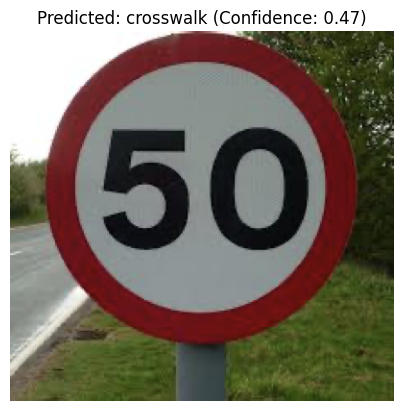

Predicted Class: crosswalk
Confidence: 0.47
Prediction Time: 0.2146 seconds


In [ ]:
# We test CNN Roadsign Classifier on any roadsign png
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

# Function to classify a new image
def classify_roadsign(image_path, model, lb):
    img = load_img(image_path, target_size=IMG_SIZE)  # Resize to the same size as training images
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class of the image
    start_time = time.time()
    predictions = model.predict(img_array)
    end_time = time.time()
    prediction_time = end_time - start_time
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = lb.classes_[predicted_class_index]
    confidence = np.max(predictions)

    plt.imshow(load_img(image_path))
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class_label} (Confidence: {confidence:.2f})")
    plt.show()

    # Print the result
    print(f"Predicted Class: {predicted_class_label}")
    print(f"Confidence: {confidence:.2f}")
    print(f"Prediction Time: {prediction_time:.4f} seconds")

    return predicted_class_label, confidence

# Example usage
image_path = "data/images/road100.png"
predicted_class, confidence = classify_roadsign(image_path, model, lb)
